<a href="https://colab.research.google.com/github/cahcharm/Neuro-and-Complexity-Science/blob/CSHA2021/tutorials/Computational%20Neuroscience/network_model/4.3_4.4_STP_Working_memory/4_4_working_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working Memory 

Implementation of the paper:

Mi, Yuanyuan, Mikhail Katkov, and Misha Tsodyks. “Synaptic correlates of working memory capacity.” Neuron 93.2 (2017): 323-330.

The basic assumption of the model is that only one memory representation can be active at any single moment, which is guaranteed by strong reciprocal connections to a global nonspecific inhibitory pool (see Figure below), consistent with experimental data (Fino and Yuste, 2011). If each memory representation had its own inhibition and hence was independent of the others, there would be no fundamental constraint to the capacity beyond the overlaps between the representations. 

<img src="working_memory.png">

In [1]:
pip install -U brainpy-simulator

     |████████████████████████████████| 126 kB 5.2 MB/s 
  Created wheel for brainpy-simulator: filename=brainpy_simulator-1.0.2-py3-none-any.whl size=152106 sha256=fb088b9291f1907658ab2422dff13b7e2f8c0595b8a56885769d035b3008d827
  Stored in directory: /root/.cache/pip/wheels/ec/1c/3f/e33093b69bc03ff9b2742480ec6126ddef875ba4f6d3699659
Successfully built brainpy-simulator


In [2]:
import numpy as np
import brainpy as bp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
dt = 0.0001  # [s]
bp.backend.set(dt=dt)

In [4]:
# sthe parameters of network
alpha = 1.5
J_EE = 8.  # the connection strength in each excitatory neural clusters
J_IE = 1.75  # Synaptic efficacy E → I
J_EI = 1.1  # Synaptic efficacy I → E
tau_f = 1.5  # time constant of STF  [s]
tau_d = .3  # time constant of STD  [s]
U = 0.3  # minimum STF value
tau = 0.008  # time constant of firing rate of the excitatory neurons [s]
tau_I = tau  # time constant of firing rate of the inhibitory neurons

Ib = 8.  # background input and external input
Iinh = 0.  # the background input of inhibtory neuron

cluster_num = 16  # the number of the clusters

In [5]:
# the parameters of external input

stimulus_num = 5
Iext_train = 225  # the strength of the external input
Ts_interval = 0.070  # the time interval between the consequent external input [s]
Ts_duration = 0.030  # the time duration of the external input [s]
duration = 2.500  # [s]

the working memory model based on STP was used to derive the expression for the postsynaptic current resulting from the activity of a large, uncorrelated pre-synaptic population.

The resulting network model has three differential equations for each of $P$ excitatory clusters (synaptic current $h_\mu$ and two STP variables $u_\mu$ and $x_\mu$ for each cluster $\mu; \mu = 1,..., P$) and one additional equation for the inhibitory pool current $h_I$:

$$
\begin{gathered}
\tau \frac{d h_{\mu}}{d t}=-h_{\mu}+J_{E E} u_{\mu} x_{\mu} R_{\mu}-J_{E l} R_{l}+I_{b}+I_{e}(t) \\
\frac{d u_{\mu}}{d t}=\frac{U-u_{\mu}}{\tau_{f}}+U\left(1-u_{\mu}\right) R_{\mu} \\
\frac{d x_{\mu}}{d t}=\frac{1-x_{\mu}}{\tau_{d}}-u_{\mu} x_{\mu} R_{\mu}, \text { and } \\
\tau \frac{d h_{I}}{d t}=-h_{I}+J_{I E} \sum_{\nu} R_{\nu}
\end{gathered}
$$

where $t$ is the neuronal time constant, for simplicity the same for excitation and inhibition; $I_b$ is the constant background excitation; and $I_e$ is the external input used to load memory items into the network. 

$$
R(h)=\alpha \ln (1+\exp (h / \alpha))
$$

is neuronal gain chosen in the form of a smoothed threshold-linear function, also the same for excitatory and inhibitory neurons. 

In [32]:
# the excitatory cluster model and the inhibitory pool model

class WorkingMemoryModel(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  def __init__(self, size, **kwargs):
    self.inh_h = 0.
    self.inh_r = self.log(self.inh_h)
    self.u = bp.ops.ones(cluster_num) * U
    self.x = bp.ops.ones(cluster_num)
    self.h = bp.ops.zeros(cluster_num)
    self.r = self.log(self.h)
    self.input = bp.ops.zeros(cluster_num)

    super(WorkingMemoryModel, self).__init__(size, **kwargs)

  @staticmethod
  @bp.odeint
  def int_exc(u, x, h, t, r, r_inh, Iext):
    du = (U - u) / tau_f + U * (1 - u) * r
    dx = (1 - x) / tau_d - u * x * r
    dh = (-h + J_EE * u * x * r - J_EI * r_inh + Iext + Ib) / tau
    return du, dx, dh

  @staticmethod
  @bp.odeint
  def int_inh(h, t, r_exc):
    h_I = (-h + J_IE * np.sum(r_exc) + Iinh) / tau_I
    return h_I

  @staticmethod
  def log(h):
    return alpha * np.log(1. + np.exp(h / alpha))

  def update(self, _t):
    self.u, self.x, self.h = self.int_exc(self.u, self.x, self.h, _t, self.r, self.inh_r, self.input)
    self.r = self.log(self.h)
    self.inh_h = self.int_inh(self.inh_h, _t, self.r)
    self.inh_r = self.log(self.inh_h)
    self.input[:] = 0.

In [33]:
# the external input

I_inputs = np.zeros((int(duration / dt), cluster_num))
for i in range(stimulus_num):
    t_start = (Ts_interval + Ts_duration) * i + Ts_interval
    t_end = t_start + Ts_duration
    idx_start, idx_end = int(t_start / dt), int(t_end / dt)
    I_inputs[idx_start: idx_end, i] = Iext_train
    
    
# model.monwork running

model = WorkingMemoryModel(cluster_num, monitors=['u', 'x', 'r', 'h'])
model.run(duration, inputs=['input', I_inputs])

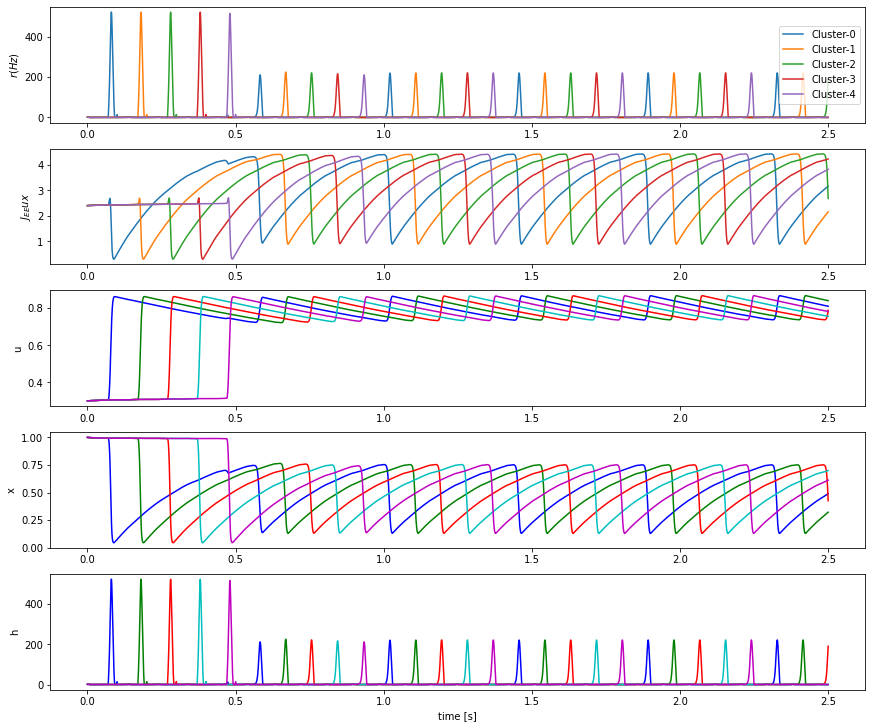

In [34]:
# visualization

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
fig.add_subplot(gs[0, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], label='Cluster-{}'.format(i))
plt.ylabel("$r (Hz)$")
plt.legend(loc='right')

fig.add_subplot(gs[1, 0])
hist_Jux = J_EE * model.mon.u * model.mon.x
for i in range(stimulus_num):
    plt.plot(model.mon.ts, hist_Jux[:, i])
plt.ylabel("$J_{EE}ux$")

fig.add_subplot(gs[2, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.u[:, i], colors[i])
plt.ylabel('u')

fig.add_subplot(gs[3, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.x[:, i], colors[i])
plt.ylabel('x')

fig.add_subplot(gs[4, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], colors[i])
plt.ylabel('h')
plt.xlabel('time [s]')

plt.show()

If stimulus_num = 4,7,9, what will happen?

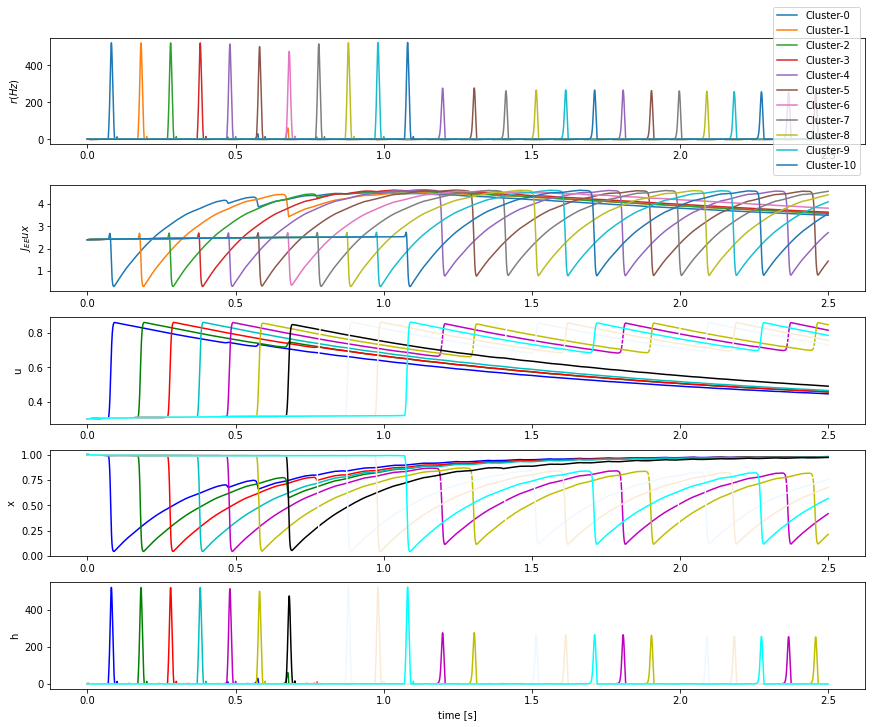

In [37]:
stimulus_num = 11

# the external input

I_inputs = np.zeros((int(duration / dt), cluster_num))
for i in range(stimulus_num):
    t_start = (Ts_interval + Ts_duration) * i + Ts_interval
    t_end = t_start + Ts_duration
    idx_start, idx_end = int(t_start / dt), int(t_end / dt)
    I_inputs[idx_start: idx_end, i] = Iext_train
    
    
# model.monwork running

model = WorkingMemoryModel(cluster_num, monitors=['u', 'x', 'r', 'h'])
model.run(duration, inputs=['input', I_inputs])

# visualization

colors = list(dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS).keys())

fig, gs = bp.visualize.get_figure(5, 1, 2, 12)
fig.add_subplot(gs[0, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], label='Cluster-{}'.format(i))
plt.ylabel("$r (Hz)$")
plt.legend(loc='right')

fig.add_subplot(gs[1, 0])
hist_Jux = J_EE * model.mon.u * model.mon.x
for i in range(stimulus_num):
    plt.plot(model.mon.ts, hist_Jux[:, i])
plt.ylabel("$J_{EE}ux$")

fig.add_subplot(gs[2, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.u[:, i], colors[i])
plt.ylabel('u')

fig.add_subplot(gs[3, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.x[:, i], colors[i])
plt.ylabel('x')

fig.add_subplot(gs[4, 0])
for i in range(stimulus_num):
    plt.plot(model.mon.ts, model.mon.r[:, i], colors[i])
plt.ylabel('h')
plt.xlabel('time [s]')

plt.show()

What's if adding STP into CANN? 